In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
jtr = pd.read_csv(r'C:\Users\tyagir01\Desktop\Train_SU63ISt.csv', index_col=[1], parse_dates=[1])
jtr.head()

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


In [3]:
jtr.index

DatetimeIndex(['2012-08-25 00:00:00', '2012-08-25 01:00:00',
               '2012-08-25 02:00:00', '2012-08-25 03:00:00',
               '2012-08-25 04:00:00', '2012-08-25 05:00:00',
               '2012-08-25 06:00:00', '2012-08-25 07:00:00',
               '2012-08-25 08:00:00', '2012-08-25 09:00:00',
               ...
               '2014-09-25 14:00:00', '2014-09-25 15:00:00',
               '2014-09-25 16:00:00', '2014-09-25 17:00:00',
               '2014-09-25 18:00:00', '2014-09-25 19:00:00',
               '2014-09-25 20:00:00', '2014-09-25 21:00:00',
               '2014-09-25 22:00:00', '2014-09-25 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=18288, freq=None)

In [4]:
jtr.drop('ID', axis='columns', inplace=True)
jtr.head()

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


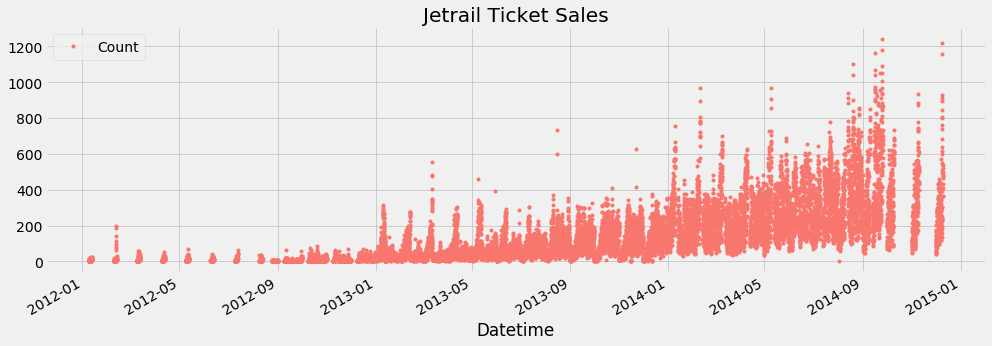

In [5]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
jtr.plot(style='.', figsize=(15,5), color=color_pal[0], title='Jetrail Ticket Sales')
plt.show()

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(jtr, label='Count')

features_and_target = pd.concat([X, y], axis=1)

In [8]:
features_and_target.tail()

,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,Count
Datetime,,,,,,,,
2014-09-25 19:00:00,19,3,9,2014,268,25,39,868
2014-09-25 20:00:00,20,3,9,2014,268,25,39,732
2014-09-25 21:00:00,21,3,9,2014,268,25,39,702
2014-09-25 22:00:00,22,3,9,2014,268,25,39,580
2014-09-25 23:00:00,23,3,9,2014,268,25,39,534


## Plotting the Features to see trends

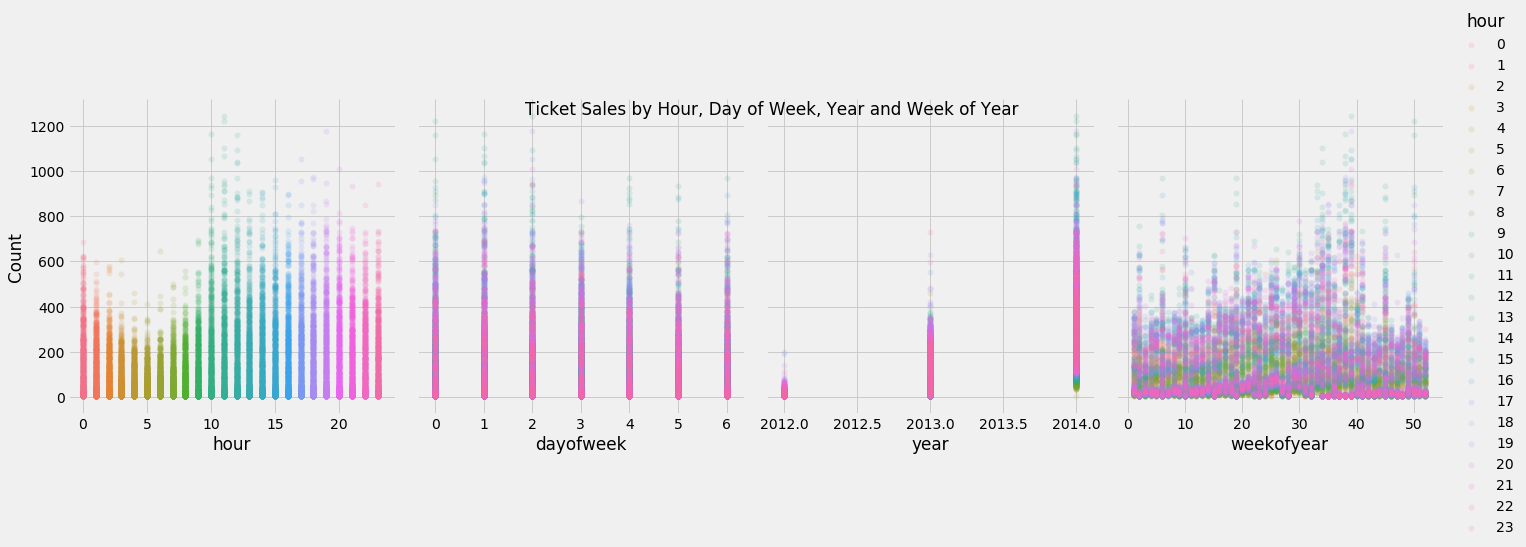

In [10]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='Count',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Ticket Sales by Hour, Day of Week, Year and Week of Year')
plt.show()

## Train Test Split

In [13]:
split_date = '30-Apr-2014'
fb_train = jtr.loc[jtr.index <= split_date].copy()
fb_test = jtr.loc[jtr.index > split_date].copy()

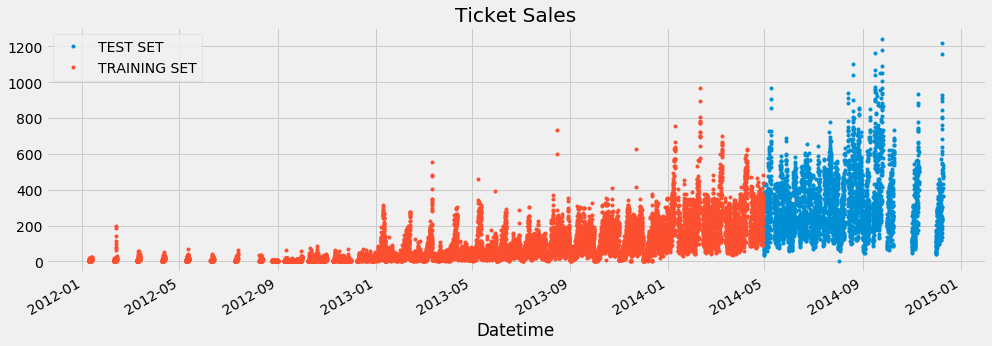

In [14]:
# Plot train and test so you can see where we have split
fb_test.rename(columns={'Count': 'TEST SET'}).join(fb_train.rename(columns={'Count': 'TRAINING SET'}),how='outer').plot(figsize=(15,5), title='Ticket Sales', style='.')
plt.show()

## Building the Simple Prophet Model

In [15]:
# Format data for prophet model using ds and y
fb_train.reset_index().rename(columns={'Datetime':'ds','Count':'y'}).head()

,ds,y
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2


In [17]:
# Setup and train model and fit
model = Prophet()
model.fit(fb_train.reset_index().rename(columns={'Datetime':'ds','Count':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [18]:
# Predict on training set with model
fb_test_fcst = model.predict(df=fb_test.reset_index().rename(columns={'Datetime':'ds'}))
fb_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-04-30 01:00:00,238.902267,158.028602,325.050659,238.902267,238.902267,1.441837,1.441837,1.441837,-9.945036,...,8.239153,8.239153,8.239153,3.147720,3.147720,3.147720,0.0,0.0,0.0,240.344103
1,2014-04-30 02:00:00,238.928346,143.512421,308.292212,238.928346,238.928346,-14.087737,-14.087737,-14.087737,-25.110045,...,7.944390,7.944390,7.944390,3.077918,3.077918,3.077918,0.0,0.0,0.0,224.840609
2,2014-04-30 03:00:00,238.954424,126.597144,298.656594,238.954424,238.954424,-26.182931,-26.182931,-26.182931,-36.865566,...,7.674243,7.674243,7.674243,3.008393,3.008393,3.008393,0.0,0.0,0.0,212.771494
3,2014-04-30 04:00:00,238.980503,126.025955,286.829123,238.980503,238.980503,-33.838075,-33.838075,-33.838075,-44.208945,...,7.431724,7.431724,7.431724,2.939146,2.939146,2.939146,0.0,0.0,0.0,205.142428
4,2014-04-30 05:00:00,239.006582,120.800809,285.017685,239.006582,239.006582,-37.922440,-37.922440,-37.922440,-48.012119,...,7.219498,7.219498,7.219498,2.870181,2.870181,2.870181,0.0,0.0,0.0,201.084142


### Plotting the forecast

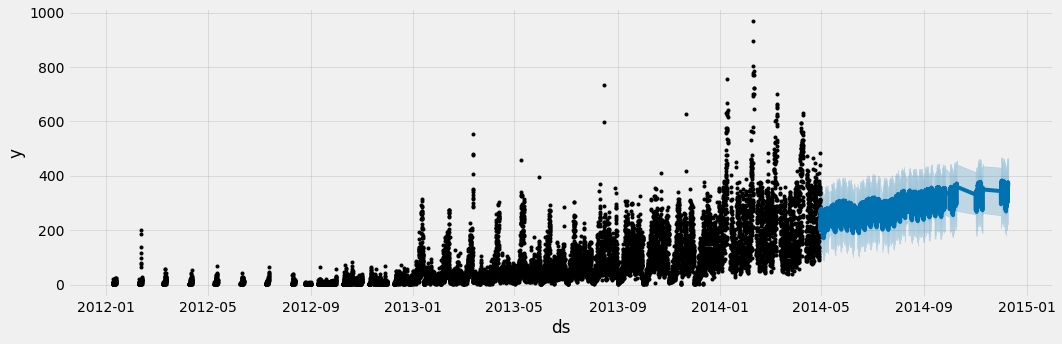

In [19]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(fb_test_fcst,ax=ax)
plt.show()

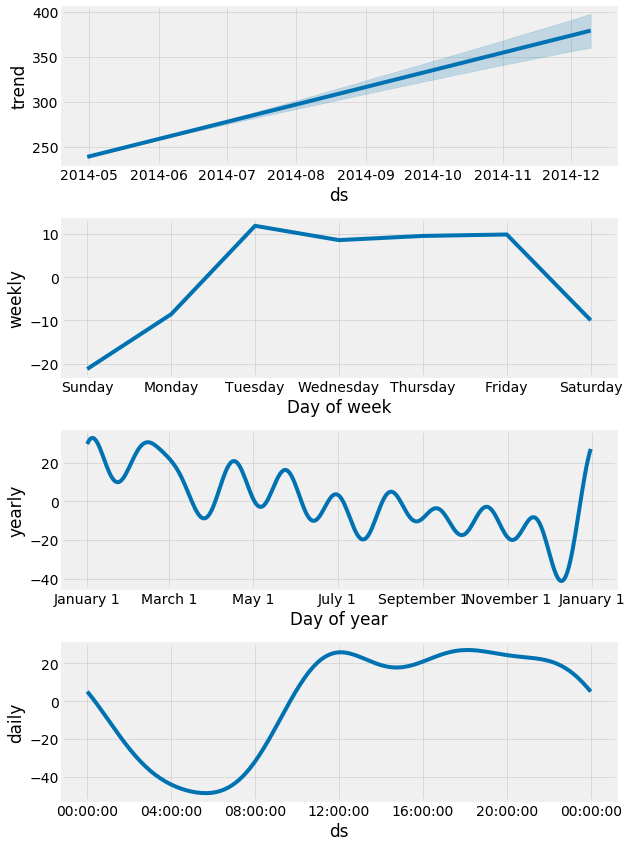

In [20]:
# Plotting the components of the model
fig = model.plot_components(fb_test_fcst)

## Compare Forecast to Actuals

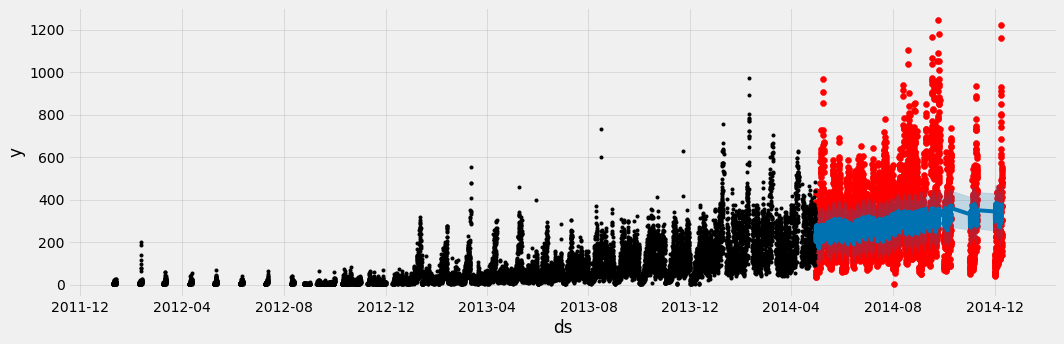

In [21]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(fb_test.index, fb_test['Count'], color='r')
fig = model.plot(fb_test_fcst, ax=ax)

## Error Metrics

In [22]:
np.sqrt(mean_squared_error(y_true=fb_test['Count'],y_pred=fb_test_fcst['yhat']))

151.865637628075

## Reading the Submission Dataset

In [29]:
jts = pd.read_csv(r'C:\Users\tyagir01\Desktop\Jet_Sub.csv', index_col=[1], parse_dates=[1])
jts

,ID
Datetime,
2014-09-26 00:00:00,18288
2014-09-26 01:00:00,18289
2014-09-26 02:00:00,18290
2014-09-26 03:00:00,18291
2014-09-26 04:00:00,18292
...,...
2015-04-26 19:00:00,23395
2015-04-26 20:00:00,23396
2015-04-26 21:00:00,23397


In [37]:
sub_fcst = model.predict(df=jts.reset_index().rename(columns={'Datetime':'ds'}))
sub_fcst.index = sub_fcst.ds

In [38]:
sub_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2014-01-10 00:00:00,2014-01-10 00:00:00,170.028395,132.029339,295.090135,170.028395,170.028395,43.172303,43.172303,43.172303,5.058659,...,9.853741,9.853741,9.853741,28.259903,28.259903,28.259903,0.0,0.0,0.0,213.200698
2014-01-10 01:00:00,2014-01-10 01:00:00,170.054474,121.343935,285.984365,170.054474,170.054474,27.557016,27.557016,27.557016,-9.945036,...,9.310956,9.310956,9.310956,28.191097,28.191097,28.191097,0.0,0.0,0.0,197.611490
2014-01-10 02:00:00,2014-01-10 02:00:00,170.080553,95.873377,268.479716,170.080553,170.080553,11.734868,11.734868,11.734868,-25.110045,...,8.722959,8.722959,8.722959,28.121955,28.121955,28.121955,0.0,0.0,0.0,181.815421
2014-01-10 03:00:00,2014-01-10 03:00:00,170.106632,87.043807,249.895322,170.106632,170.106632,-0.721265,-0.721265,-0.721265,-36.865566,...,8.091821,8.091821,8.091821,28.052480,28.052480,28.052480,0.0,0.0,0.0,169.385366
2014-01-10 04:00:00,2014-01-10 04:00:00,170.132710,77.024553,243.312185,170.132710,170.132710,-8.806411,-8.806411,-8.806411,-44.208945,...,7.419856,7.419856,7.419856,27.982677,27.982677,27.982677,0.0,0.0,0.0,161.326299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-04 19:00:00,2015-12-04 19:00:00,604.264986,477.357512,704.882828,521.991247,681.044553,-13.995038,-13.995038,-13.995038,26.193278,...,-5.542077,-5.542077,-5.542077,-34.646239,-34.646239,-34.646239,0.0,0.0,0.0,590.269948
2015-12-04 20:00:00,2015-12-04 20:00:00,604.291064,473.903427,704.292075,521.998488,681.080000,-16.828791,-16.828791,-16.828791,24.361443,...,-6.454244,-6.454244,-6.454244,-34.735990,-34.735990,-34.735990,0.0,0.0,0.0,587.462274
2015-12-04 21:00:00,2015-12-04 21:00:00,604.317143,465.251831,692.921419,522.011489,681.115447,-19.087563,-19.087563,-19.087563,23.093129,...,-7.355373,-7.355373,-7.355373,-34.825320,-34.825320,-34.825320,0.0,0.0,0.0,585.229580


In [36]:
df_sub = sub_fcst[['yhat']]
df_sub

,yhat
ds,
2014-01-10 00:00:00,213.200698
2014-01-10 01:00:00,197.611490
2014-01-10 02:00:00,181.815421
2014-01-10 03:00:00,169.385366
2014-01-10 04:00:00,161.326299
...,...
2015-12-04 19:00:00,590.269948
2015-12-04 20:00:00,587.462274
2015-12-04 21:00:00,585.229580


In [42]:
df_sub = df_sub.round(0).astype(int)
df_sub

,yhat
ds,
2014-01-10 00:00:00,213
2014-01-10 01:00:00,198
2014-01-10 02:00:00,182
2014-01-10 03:00:00,169
2014-01-10 04:00:00,161
...,...
2015-12-04 19:00:00,590
2015-12-04 20:00:00,587
2015-12-04 21:00:00,585


In [44]:
df_sub.to_csv('JetRail_Predictions.csv')